<a href="https://colab.research.google.com/github/itimes-digital/deep-learning-estudo/blob/main/convolutional_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uso de camada convolucional para redução de dimensionalidade.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

In [3]:
(previsores_treinamento, _), (previsores_teste, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
previsores_treinamento = previsores_treinamento.reshape((len(previsores_treinamento), 28, 28, 1))
previsores_teste = previsores_teste.reshape((len(previsores_teste), 28, 28, 1))

previsores_treinamento.shape, previsores_teste.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
previsores_treinamento = previsores_treinamento.astype('float32') / 255
previsores_teste = previsores_teste.astype('float32') / 255

## Parte do modelo será para reduzir a imagem usando as camadas convolucionais

In [15]:
auto_encoder = Sequential()

#Encoder - início
auto_encoder.add(Conv2D(filters = 16, 
                       kernel_size = (3,3), 
                       activation = 'relu',
                       input_shape = (28,28,1)))
auto_encoder.add(MaxPooling2D(pool_size = (2,2)))

auto_encoder.add(Conv2D(filters = 8, 
                       kernel_size = (3,3), 
                       activation = 'relu',
                       padding = 'same'))
auto_encoder.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

# 4, 4, 8
auto_encoder.add(Conv2D(filters = 8, 
                       kernel_size = (3,3), 
                       activation = 'relu',
                       padding = 'same',
                       strides = (2,2))) #default é (1,1)

auto_encoder.add(Flatten())# Vetor com 128 posições (4 * 4 * 8)

auto_encoder.add(Reshape((4,4,8)))
#Encoder - fim

## Última parte do modelo será para decodificar a imagem reduzida em imagem original.

In [16]:
#Decoder - início
auto_encoder.add(Conv2D(filters = 8, 
                       kernel_size = (3,3), 
                       activation = 'relu',
                       padding = 'same'))
auto_encoder.add(UpSampling2D(size = (2,2)))

auto_encoder.add(Conv2D(filters = 8, 
                       kernel_size = (3,3), 
                       activation = 'relu',
                       padding = 'same'))
auto_encoder.add(UpSampling2D(size = (2,2)))

auto_encoder.add(Conv2D(filters = 16, 
                       kernel_size = (3,3), 
                       activation = 'relu'))
auto_encoder.add(UpSampling2D(size = (2,2)))

auto_encoder.add(Conv2D(filters = 1, 
                       kernel_size = (3,3), 
                       activation = 'sigmoid',
                       padding = 'same'))
#Decoder - fim

In [17]:
auto_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)          

In [ ]:
auto_encoder.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

history = auto_encoder.fit(previsores_treinamento, previsores_treinamento,
                           epochs = 50, batch_size = 256,
                           validation_data = (previsores_teste, previsores_teste))

In [22]:
np.mean(history.history['val_accuracy'])

0.8109190261363983

In [24]:
encoder = Model(inputs = auto_encoder.input, outputs = auto_encoder.get_layer('flatten_1').output)
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [27]:
previsores_teste.shape

(10000, 28, 28, 1)

In [25]:
imagens_codificadas = encoder.predict(previsores_teste)
imagens_codificadas.shape

(10000, 128)

In [26]:
imagens_decodificadas = auto_encoder.predict(previsores_teste)
imagens_decodificadas.shape

(10000, 28, 28, 1)

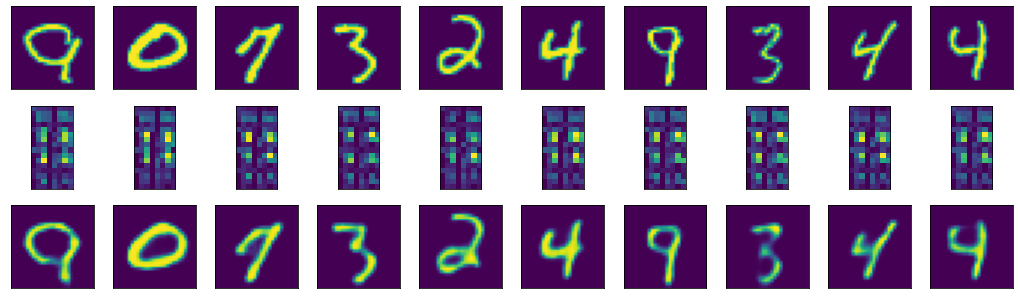

In [33]:
numero_imagens = 10
imagens_teste = np.random.randint(previsores_teste.shape[0], size = numero_imagens);

plt.figure(figsize = (18,18))

for i, indice_imagem in enumerate(imagens_teste):
  
  # Imagens originais
  eixo = plt.subplot(10,10, i + 1)
  plt.imshow(previsores_teste[indice_imagem].reshape(28,28))
  plt.xticks(())
  plt.yticks(())

  # Imagens codificadas
  eixo = plt.subplot(10,10, i + 1 + numero_imagens)
  plt.imshow(imagens_codificadas[indice_imagem].reshape(16,8))
  plt.xticks(())
  plt.yticks(())

  # Imagens reconstruída
  eixo = plt.subplot(10,10, i + 1 + numero_imagens * 2)
  plt.imshow(imagens_decodificadas[indice_imagem].reshape(28,28))
  plt.xticks(())
  plt.yticks(())

plt.show()